## Data Splitting, Preprocessing, Baseline Model


In [1]:
# Import necessary libraries


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, plot_confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.dummy import DummyClassifier

In [3]:
# Load cleaned dataframe

In [4]:
df = pd.read_csv(
'./Data/Cleaned_Terry_Stops.csv')

In [5]:
df.head()

,Unnamed: 0,Subject Age Group,Stop Resolution,Weapon Type,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag
0,0,36 - 45,Field Contact,Unknown,White,Male,"DISTURBANCE, MISCELLANEOUS/OTHER",DISTURBANCE - OTHER,0,0
1,1,46 - 55,Field Contact,Unknown,White,Male,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0
2,2,26 - 35,Field Contact,No Weapons,White,Male,Unknown,Unknown,0,0
3,3,Unknown,Field Contact,Unknown,Black or African American,Male,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0
4,4,26 - 35,Field Contact,Unknown,Unknown,Female,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,0,0


In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [101]:
df.shape

(2255432, 9)

In [103]:
# 2,255,432 rows are too huge. decease it to 250k rows

In [106]:
df = df.sample(n=250000, replace=False, weights=None, random_state=42)

# Perform a Dummy Classifier Model.
# Features: Subject Age Group, Stop Resolution, Weapon Type, Subject Perceived Race, Gender, Initial Call Type, Final Call Type, Frisk Flag
1. Define X and y
2. Train Test Split
3. Preprocessing
4. Modeling
5. Predict, Evaluate

In [107]:
X = df.drop('Arrest Flag', axis = 1)
y = df['Arrest Flag']

In [109]:
# Do (60, 20, 20) data split

In [110]:
X_train_touch, X_test, y_train_touch, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_touch, y_train_touch, test_size = 0.25, random_state= 42)

In [111]:
# create a mini-pipelines into our ColumnTransformer: categorical

subpipe_cat = Pipeline(steps = [
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

# Create a column transformer
# passthrough leaves the other df columns unchanged.

CT = ColumnTransformer( transformers = [
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

In [11]:
## Use SMOTE to balance the minority class

In [12]:
## BRING IN OUR MODELING CLASS FROM BEFORE, COPIED THE BELOW CODES FROM LECTURE PIPELINE

In [112]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [113]:
# Dummy model pipeline
dum_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dum', DummyClassifier(strategy="most_frequent"))
])

In [114]:
dum_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa33ed99400>)])),
                ('dum', DummyClassifier(strategy='most_frequent'))])

In [118]:
dum_model_pipe.score(X_train, y_train)

0.9023366666666667

In [119]:
dum_model_pipe.score(X_val, y_val)

0.90143

<AxesSubplot:title={'center':'CV Results for `dum` Model'}>

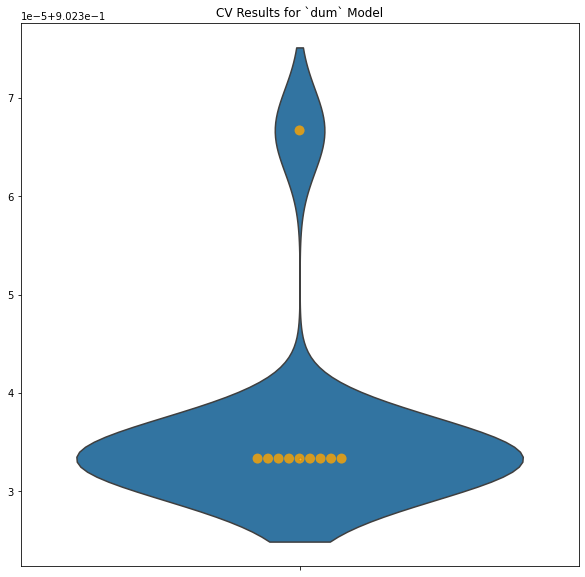

In [120]:
dum_pipe = ModelWithCV(
    dum_model_pipe,
    model_name='dum',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

dum_pipe.plot_cv(ax=ax)

In [121]:
dum_pipe.print_cv_summary()

CV Results for `dum` model:
            0.90234 ± 0.00001 accuracy
        


In [ ]:
y_val_pred = dum_model_pipe.predict(X_val)

Dummy classifiers are mainly used for performance evaluation and can help to identify if a model is actually learning meaningful patterns or if the performance achieved is merely due to the class distribution in the dataset.

# Create First Logisitc Regression Model

# Features: Subject Age Group, Stop Resolution, Weapon Type, Subject Perceived Race, Gender, Initial Call Type, Final Call Type, Frisk Flag

In [122]:
# Create FSM (First Simple Model)
## Use SMOTE to bring up the minority class to 33% (Minority), 66% (Majority)

logreg_model_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm', SMOTE(sampling_strategy=0.5, random_state = 42)), # setting minority half of majority
    ('fsm', LogisticRegression(random_state = 42))
])

In [126]:
logreg_model_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa33ed99400>)])),
                ('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('fsm', LogisticRegression(random_state=42))])

In [127]:
fsm_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='FSM',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

fsm_pipe.plot_cv(ax=ax)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

KeyboardInterrupt: 

In [79]:
fsm_pipe.print_cv_summary()

CV Results for `FSM` model:
            0.98894 ± 0.00056 accuracy
        


In [17]:
logreg_model_pipe.score(X_val,y_val) # accuracy of the model with validation set

0.989733687736512

## Observation: First baseline model has an accuracy of  X% on the training and X% on the validation set.

# This doesn't look realistic.

    # How do I know how each feature contribute to the model?
    # Looking at coefficients, statsmodel pvalues
    # Reduce some features

In [ ]:
### checking RandomUnderSampler working or not ### HOW DO I KNOW?? IF THE CLASS IS BALANCED?

In [18]:
y_train.value_counts()

0    1220410
1     132848
Name: Arrest Flag, dtype: int64

   ## 2nd Logistic Model: Reduce features to 3 ( Weapon Type, Subject Age Group, Frisk Flag)

In [ ]:
# Use the same training and validation sets to do this model with 3 features

In [41]:
X_train_2 = X_train[['Weapon_Type','Subject Age Group','Frisk Flag']]
X_val_2 = X_val[['Weapon_Type','Subject Age Group','Frisk Flag']]
y_train_2 = y_train
y_val_2 = y_val

In [42]:
X_train_2.shape

(1353258, 3)

In [43]:
X_val_2.shape

(451087, 3)

In [44]:
X_test_2.shape

(451087, 3)

In [45]:
logreg_model_pipe.fit(X_train_2, y_train_2)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7e086ee80>)])),
                ('rus', RandomUnderSampler(random_state=42)),
                ('fsm', LogisticRegression(random_state=42))])

In [ ]:
logre2_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='logre2',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

logre2_pipe.plot_cv(ax=ax)

In [46]:
logreg_model_pipe.score(X_val_2, y_val_2)

0.6994542060715695

In [48]:
logre2_pipe.print_cv_summary()

0.6995368964301787

In [50]:
# Reduce to 3 features, now accuracy is ??% for training and ??% for val

In [51]:
# ROC AUC Evaluation!

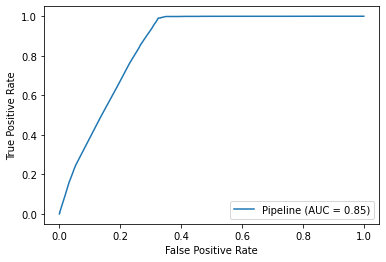

In [53]:
plot_roc_curve(logreg_model_pipe, X_val_2, y_val_2)

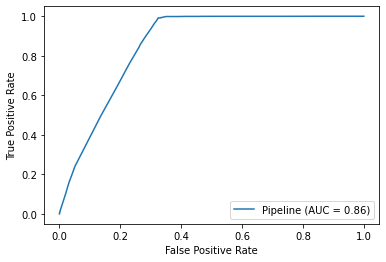

In [55]:
plot_roc_curve(logreg_model_pipe, X_test_2, y_test_2)

In [56]:
## AUC is about 0.86.

# 3nd Logistic Model: Reduce features to 2 ( Weapon Type, Frisk Flag)
# To see how Age of the subject impact the physical arrest flag

In [61]:
X_3 = df[['Weapon Type','Frisk Flag']]
y_3 = df['Arrest Flag']

In [62]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size = 0.2, random_state=42)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_train_3, y_train_3, test_size = 0.25, random_state= 42)

In [66]:
logreg_model_pipe.fit(X_train_3, y_train_3)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7e086ee80>)])),
                ('rus', RandomUnderSampler(random_state=42)),
                ('fsm', LogisticRegression(random_state=42))])

In [67]:
logreg_model_pipe.score(X_train_3, y_train_3)

0.6831941876567513

In [68]:
logreg_model_pipe.score(X_val_3, y_val_3)

0.6835931871235482

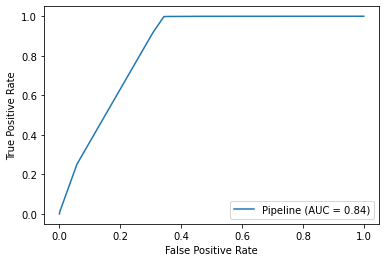

In [69]:
plot_roc_curve(logreg_model_pipe, X_train_3, y_train_3)

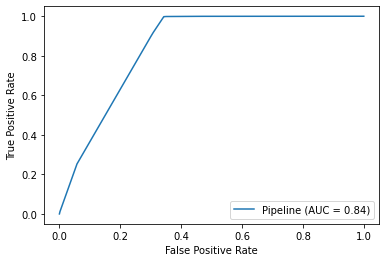

In [70]:
plot_roc_curve(logreg_model_pipe, X_val_3, y_val_3)

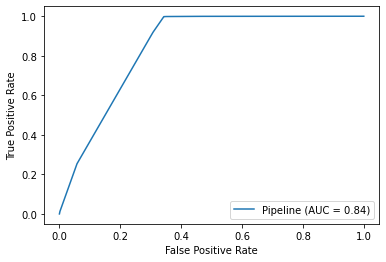

In [71]:
plot_roc_curve(logreg_model_pipe, X_test_3, y_test_3)

In [72]:
# AUC stays the same when comparing features with or without age of subjects 
# Accuracy lowers 2% without considering age of the subject.

## 4th Logistic Model:  3 features ( Weapon Type, Gender, Frisk Flag)

In [73]:
X_4 = df[['Weapon Type','Subject Perceived Gender','Frisk Flag']]
y_4 = df['Arrest Flag']

In [74]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size = 0.2, random_state=42)

X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(X_train_4, y_train_4, test_size = 0.25, random_state= 42)

In [75]:
logreg_model_pipe.fit(X_train_4, y_train_4)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7e086ee80>)])),
                ('rus', RandomUnderSampler(random_state=42)),
                ('fsm', LogisticRegression(random_state=42))])

In [76]:
logreg_model_pipe.score(X_train_4, y_train_4)

0.6849861593280808

In [77]:
logreg_model_pipe.score(X_val_4, y_val_4)

0.6853511628577192

In [78]:
# Gender does not really contribute to the finding

# 5th Logistic Model: 1 feature ( Weapon Type)